## SAADALLAH Ahmed & KHELILI Adrian

In [2]:
import numpy as np 
np.set_printoptions(threshold=10000,suppress=True) 
import pandas as pd
import warnings
import matplotlib.pyplot as plt 
warnings.filterwarnings('ignore')

# Partie 1

### Chargement des données et préparation

In [3]:
credit=pd.read_csv('./datas/credit_scoring.csv',sep=";",header=0)

In [4]:
credit.head(3)
nom_cols = credit.columns

In [5]:
credit.shape

(4375, 14)

In [6]:
X=credit.iloc[:,:13].values
Y=credit.iloc[:,13].values

In [7]:
mp=100*np.sum(Y==0)/len(Y)
bp=100*np.sum(Y==1)/len(Y)

print("% Bon payeurs : {0:.2f} % Mauvais payeurs : {1:.2f}".format(bp,mp))

% Bon payeurs : 72.21 % Mauvais payeurs : 27.79


In [8]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import BaggingClassifier

In [9]:
Xtrain,Xtest,Ytrain,Ytest=train_test_split(X,Y,test_size=0.5,random_state=1)

## Lancement des classifieurs

In [10]:
def classifieurs(Xtrain,Xtest,Ytrain,Ytest):
    DT=DecisionTreeClassifier(criterion='gini',random_state=1) #CART
    DT.fit(Xtrain,Ytrain)
    YDT=DT.predict(Xtest)

    print("Arbre de décision : Accuracy = {0:.2f}".format(accuracy_score(Ytest,YDT)*100))
    print(confusion_matrix(Ytest,YDT))

    print()

    KNN=KNeighborsClassifier(n_neighbors=5) #KNN
    KNN.fit(Xtrain,Ytrain)
    YKNN=KNN.predict(Xtest)

    print("KNN : Accuracy = {0:.2f}".format(accuracy_score(Ytest,YKNN)*100))
    print(confusion_matrix(Ytest,YKNN))

    print()

In [11]:
classifieurs(Xtrain,Xtest,Ytrain,Ytest)

Arbre de décision : Accuracy = 72.71
[[ 325  279]
 [ 318 1266]]

KNN : Accuracy = 72.49
[[ 189  415]
 [ 187 1397]]



### Normalisation des données

In [12]:
SS=StandardScaler()
SS.fit(Xtrain)
Xtrain_norm=SS.transform(Xtrain)
Xtest_norm=SS.transform(Xtest)

classifieurs(Xtrain_norm,Xtest_norm,Ytrain,Ytest)

Arbre de décision : Accuracy = 72.71
[[ 322  282]
 [ 315 1269]]

KNN : Accuracy = 75.27
[[ 286  318]
 [ 223 1361]]



### Création de nouvelles variables caractéristiques par combinaisons linéaires des variables initiales

In [13]:
pca=PCA(n_components=3)
pca.fit(Xtrain_norm)
Xtrain_pca=np.concatenate((Xtrain_norm,pca.transform(Xtrain_norm)),axis=1)
Xtest_pca=np.concatenate((Xtest_norm,pca.transform(Xtest_norm)),axis=1)
classifieurs(Xtrain_pca,Xtest_pca,Ytrain,Ytest)


Arbre de décision : Accuracy = 73.63
[[ 351  253]
 [ 324 1260]]

KNN : Accuracy = 75.64
[[ 283  321]
 [ 212 1372]]



In [14]:
BAG=BaggingClassifier(n_estimators=100,random_state=1) #BAG
BAG.fit(Xtrain,Ytrain)
YBAG=BAG.predict(Xtest)
print("Bagging : Accuracy = {0:.2f}".format(accuracy_score(Ytest,YBAG)*100))
print(confusion_matrix(Ytest,YBAG))

Bagging : Accuracy = 78.56
[[ 332  272]
 [ 197 1387]]


### Sélection de variables

In [15]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100)
clf.fit(Xtrain_norm, Ytrain)
importances=clf.feature_importances_
var = [tree.feature_importances_ for tree in clf.estimators_]
std = np.std([tree.feature_importances_ for tree in clf.estimators_],axis=0)
sorted_idx = np.argsort(importances)[::-1]
features =nom_cols

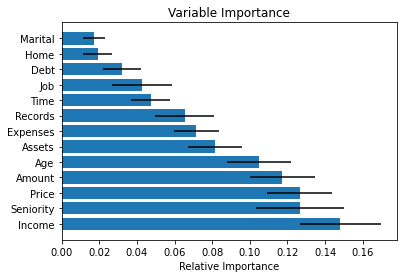

In [16]:
padding = np.arange(Xtrain_norm.size/len(Xtrain_norm)) + 0.5
plt.barh(padding, importances[sorted_idx],xerr=std[sorted_idx], align='center')
plt.yticks(padding, features[sorted_idx])
plt.xlabel("Relative Importance")
plt.title("Variable Importance")
plt.show()

In [17]:
KNN=KNeighborsClassifier(n_neighbors=5)
scores=np.zeros(Xtrain_norm.shape[1]+1)
for f in np.arange(0, Xtrain_norm.shape[1]+1):
    X1_f = Xtrain_norm[:,sorted_idx[:f+1]]
    X2_f = Xtest_norm[:,sorted_idx[:f+1]]
    KNN.fit(X1_f,Ytrain)
    YKNN=KNN.predict(X2_f)
    scores[f]=np.round(accuracy_score(Ytest,YKNN),3)

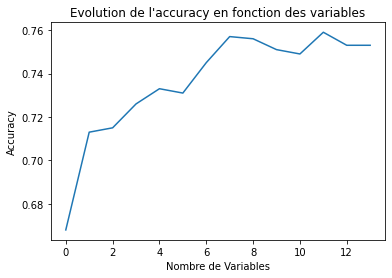

In [18]:
plt.plot(scores)
plt.xlabel("Nombre de Variables")
plt.ylabel("Accuracy")
plt.title("Evolution de l'accuracy en fonction des variables")
plt.show()

In [19]:
Xtrain_norm_select = Xtrain_norm[:,sorted_idx[:11]] 
Xtest_norm_select = Xtest_norm[:,sorted_idx[:11]]

### Random Forest Model hyperparameters

In [20]:
# Number of trees in random forest
criterion = ["gini", "entropy"]
# -----
max_features = ["sqrt","log2"]
# Number of features at every split
splitter = ["best", "random"]
# Max number of levels
max_depth = [None,2,3,4]
# Min npumber of samples to split a node 
min_samples_split=[2,5,7]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1,3,5]
# random_state 
random_state = [0]

In [21]:
param_grid = {
    'criterion': criterion,
    'splitter':splitter,
    'max_depth':max_depth,
    'min_samples_split':min_samples_split,
    'min_samples_leaf':min_samples_leaf,
    'max_features': max_features,
    'random_state': random_state
}

In [22]:
tree = DecisionTreeClassifier()

In [23]:
from sklearn.model_selection import GridSearchCV

tree_tuner= GridSearchCV(estimator = tree, param_grid= param_grid, cv=10, verbose=2, n_jobs=4)

In [24]:
tree_tuner.fit(Xtrain_norm, Ytrain)

Fitting 10 folds for each of 288 candidates, totalling 2880 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 2873 out of 2880 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=4)]: Done 2880 out of 2880 | elapsed:    2.2s finished


GridSearchCV(cv=10, estimator=DecisionTreeClassifier(), n_jobs=4,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 2, 3, 4],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 3, 5],
                         'min_samples_split': [2, 5, 7], 'random_state': [0],
                         'splitter': ['best', 'random']},
             verbose=2)

In [25]:
tree_tuner.best_params_

{'criterion': 'entropy',
 'max_depth': 4,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'random_state': 0,
 'splitter': 'best'}

In [26]:
print(tree_tuner.score(Xtest_norm,Ytest))

0.7513711151736746


In [27]:
# model Knn que nous allons tuner
knn = KNeighborsClassifier()

### knn hyperparameters

In [28]:
# nombre de voisins
n_neighbors = [x for x in range(3,12,2)]
# puissance minkowski
# 1 to get manhattan distance and 2 for ecludien distance
p = [1,2] 
# weights
weights = ["uniform", "distance"]
# algorithms
algorithms = ["ball_tree", "kd_tree", "brute"]

In [29]:
param_grid_KNN = {
    'n_neighbors': n_neighbors,
    'weights' : weights,
    'algorithm' : algorithms
}

In [30]:
knn_tuner = GridSearchCV(estimator = knn, param_grid= param_grid_KNN, cv=10, verbose=2, n_jobs=4)

In [31]:
knn_tuner.fit(Xtrain_norm, Ytrain)

Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 136 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    1.3s finished


GridSearchCV(cv=10, estimator=KNeighborsClassifier(), n_jobs=4,
             param_grid={'algorithm': ['ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': [3, 5, 7, 9, 11],
                         'weights': ['uniform', 'distance']},
             verbose=2)

In [32]:
knn_tuner.best_params_

{'algorithm': 'ball_tree', 'n_neighbors': 11, 'weights': 'distance'}

In [33]:
print(knn_tuner.score(Xtest_norm,Ytest))

0.7751371115173674


### Pipeline

In [31]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

In [35]:
pipe = Pipeline([('norm', StandardScaler()),('ACP', PCA(n_components=3))])
union_norm_pca = FeatureUnion(transformer_list=[('norm',StandardScaler()),('pipe',pipe)])

In [36]:
pipe_knn = Pipeline([("union",union_norm_pca), ('rf', KNeighborsClassifier(algorithm = 'ball_tree',
                                                                                             n_neighbors = 11,
                                                                                             weights = 'distance'))])

In [37]:
pipe_knn.fit(Xtrain,Ytrain)
pipe_knn.score(Xtest, Ytest)

0.7641681901279708

In [38]:
from sklearn.metrics import recall_score, precision_score
Y_P = pipe_knn.predict(Xtest)
recall_score(Ytest, Y_P)

0.8901515151515151

In [39]:
precision_score(Ytest, Y_P)

0.8047945205479452

In [40]:
import pickle

In [41]:
filename = 'models/knn_model.sav'

In [42]:
pickle.dump(pipe_knn, open(filename, 'wb'))

In [43]:
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(Xtest, Ytest)
print(result)

0.7641681901279708


### Comparaison de plusieurs algorithmes d’apprentissage

In [10]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, RandomForestClassifier
import time
clfs = {
 'CART': DecisionTreeClassifier(criterion="gini",random_state=1),
 'ID3' : DecisionTreeClassifier(criterion="entropy",random_state=1),
 'DSTUMP' : DecisionTreeClassifier(max_depth=1,random_state=1),
 'MLP' : MLPClassifier(hidden_layer_sizes=(20,10), random_state=1), # the best with 0.781 accuracy
 'KNN' : KNeighborsClassifier(algorithm = 'ball_tree',n_neighbors = 11, weights = 'distance'),
 'NB' : GaussianNB(),
 'BAGGING' : BaggingClassifier(n_estimators=50, random_state=1), 
 'BAGGING_KNN' : BaggingClassifier(base_estimator=KNeighborsClassifier(algorithm = 'ball_tree',n_neighbors = 11, weights = 'distance'), n_estimators=50, random_state=1), 
 'BOOSTING' : AdaBoostClassifier( n_estimators=50, random_state=1),
 'RF' : RandomForestClassifier(n_estimators=100,criterion='gini',random_state=1)
}

In [11]:
def run_classifiers(X, Y, classifiers, multi_class = True):
    kf = KFold(n_splits=10, shuffle=True, random_state=0)
    kf2 = KFold(n_splits=5, shuffle=True, random_state=0)
    for i in classifiers:
        clf = classifiers[i]
        before= time.time()
        cv_acc = cross_val_score(clf, X, Y, cv=kf)
        after = time.time()
        print("---------------------------")
        exec_time = after-before
        print("Time for {0} to train is : {1}".format(i, exec_time))
        print("Accuracy for {0} is: {1:.3f} +/- {2:.3f}".format(i, np.mean(cv_acc), np.std(cv_acc)))
        cv_auc = cross_val_score(clf, X, Y , cv=kf, scoring='roc_auc')
        cv_prec = cross_val_score(clf, X, Y, cv=kf2, scoring='precision')
        print("AUC for {0} is: {1:.3f} +/- {2:.3f}".format(i, np.mean(cv_auc), np.std(cv_auc)))
        print("Precision for {0} is: {1:.3f} +/- {2:.3f}".format(i, np.mean(cv_prec), np.std(cv_prec)))

In [46]:
run_classifiers(Xtrain_norm, Ytrain, clfs)

---------------------------
Time for CART to train is : 0.09816527366638184
Accuracy for CART is: 0.709 +/- 0.030
AUC for CART is: 0.641 +/- 0.038
Precision for CART is: 0.793 +/- 0.023
---------------------------
Time for ID3 to train is : 0.10968899726867676
Accuracy for ID3 is: 0.704 +/- 0.034
AUC for ID3 is: 0.629 +/- 0.036
Precision for ID3 is: 0.788 +/- 0.019
---------------------------
Time for DSTUMP to train is : 0.016617536544799805
Accuracy for DSTUMP is: 0.721 +/- 0.028
AUC for DSTUMP is: 0.617 +/- 0.034
Precision for DSTUMP is: 0.739 +/- 0.036
---------------------------
Time for MLP to train is : 11.706866264343262
Accuracy for MLP is: 0.792 +/- 0.019
AUC for MLP is: 0.838 +/- 0.017
Precision for MLP is: 0.838 +/- 0.025
---------------------------
Time for KNN to train is : 0.19351649284362793
Accuracy for KNN is: 0.764 +/- 0.020
AUC for KNN is: 0.778 +/- 0.015
Precision for KNN is: 0.803 +/- 0.019
---------------------------
Time for NB to train is : 0.02880120277404785


# Apprentissage supervisé : données hétérogènes

#### Chargement des données et préparation

In [49]:
credit2=pd.read_csv('./datas/credit.data',sep="\t",header=0).to_numpy()

In [50]:
X2_Brut = credit2[:,:15]
Y2_Brut = credit2[:, 15:]

In [51]:
X2_numeric_train = X2_Brut[:,[1,2,7,10,13,14]]
X2_numeric_with_nan = np.where(X2_numeric_train=='?', np.nan, X2_numeric_train)

In [52]:
X2_Train = X2_numeric_with_nan.astype(float)
index_without_nan = ~np.isnan(X2_Train).any(axis=1)
X2_Train = X2_Train[index_without_nan]
Y2_Train = Y2_Brut[index_without_nan]

In [53]:
print(X2_Train.shape)
print(Y2_Train.shape)
print(np.histogram(Y2_Train, bins=['+', '-']))

(665, 6)
(665, 1)
(array([665]), array(['+', '-'], dtype='<U1'))


In [54]:
unique, counts = np.unique(Y2_Train, return_counts=True)
dict(zip(unique, counts))

{'+': 298, '-': 367}

In [55]:
Y2_Train = np.where(Y2_Train=='+', 1, 0)

In [56]:
run_classifiers(X2_Train, Y2_Train, clfs)

---------------------------
Time for CART to train is : 0.03658413887023926
Accuracy for CART is: 0.716 +/- 0.058
AUC for CART is: 0.717 +/- 0.049
Precision for CART is: 0.656 +/- 0.040
---------------------------
Time for ID3 to train is : 0.03465867042541504
Accuracy for ID3 is: 0.702 +/- 0.055
AUC for ID3 is: 0.704 +/- 0.049
Precision for ID3 is: 0.677 +/- 0.042
---------------------------
Time for DSTUMP to train is : 0.012306928634643555
Accuracy for DSTUMP is: 0.744 +/- 0.054
AUC for DSTUMP is: 0.723 +/- 0.035
Precision for DSTUMP is: 0.866 +/- 0.049
---------------------------
Time for MLP to train is : 1.3405144214630127
Accuracy for MLP is: 0.661 +/- 0.080
AUC for MLP is: 0.703 +/- 0.089
Precision for MLP is: 0.716 +/- 0.073
---------------------------
Time for KNN to train is : 0.018004655838012695
Accuracy for KNN is: 0.687 +/- 0.045
AUC for KNN is: 0.735 +/- 0.056
Precision for KNN is: 0.736 +/- 0.070
---------------------------
Time for NB to train is : 0.01361346244812011

### Normalisation des variables continues

In [77]:
Snorm=StandardScaler()
Snorm.fit(X2_Train)
X2_Train_norm=Snorm.transform(X2_Train)

In [78]:
run_classifiers(X2_Train_norm, Y2_Train, clfs)

---------------------------
Time for CART to train is : 0.03393959999084473
Accuracy for CART is: 0.713 +/- 0.057
AUC for CART is: 0.713 +/- 0.049
Precision for CART is: 0.655 +/- 0.038
---------------------------
Time for ID3 to train is : 0.04208564758300781
Accuracy for ID3 is: 0.702 +/- 0.058
AUC for ID3 is: 0.703 +/- 0.052
Precision for ID3 is: 0.677 +/- 0.042
---------------------------
Time for DSTUMP to train is : 0.014469146728515625
Accuracy for DSTUMP is: 0.744 +/- 0.054
AUC for DSTUMP is: 0.723 +/- 0.035
Precision for DSTUMP is: 0.866 +/- 0.049
---------------------------
Time for MLP to train is : 5.253662347793579
Accuracy for MLP is: 0.777 +/- 0.053
AUC for MLP is: 0.838 +/- 0.045
Precision for MLP is: 0.814 +/- 0.058
---------------------------
Time for KNN to train is : 0.02859807014465332
Accuracy for KNN is: 0.744 +/- 0.046
AUC for KNN is: 0.828 +/- 0.040
Precision for KNN is: 0.813 +/- 0.026
---------------------------
Time for NB to train is : 0.016204357147216797


#### Traitement de données manquantes 

In [148]:
col_cat= np.array([0,3,4,5,6,8,9,11,12])

In [133]:
X_cat = np.copy(X2_Brut[:, col_cat])

for col_id in range(len(col_cat)):
    unique_val, val_idx = np.unique(X_cat[:, col_id], return_inverse=True)
    X_cat[:, col_id] = val_idx

In [139]:
from sklearn.impute import SimpleImputer 

In [145]:
imp_cat = SimpleImputer(missing_values=0, strategy='most_frequent')
X_cat[:,range(5)] = imp_cat.fit_transform(X_cat[:,range(5)]) 

In [183]:
col_num= np.array([1,2,7,10,13,14])
X_num = np.copy(X2_Brut[:, col_num])
X_num[X_num == '?'] = np.nan
X_num = X_num.astype(float)
imp_num = SimpleImputer(missing_values=np.nan, strategy='mean')
X_num = imp_num.fit_transform(X_num)

In [184]:
from sklearn.preprocessing import OneHotEncoder

In [185]:
X_cat_bin = OneHotEncoder().fit_transform(X_cat).toarray()

In [188]:
Snorm_num=StandardScaler()
Snorm_num.fit(X_num)
X2_num_norm=Snorm.transform(X_num)

In [189]:
X2_train_num_cat= np.concatenate((X_cat_bin, X2_num_norm), axis=1)
run_classifiers(X2_Train_norm, Y2_Train, clfs)

---------------------------
Time for CART to train is : 0.03948616981506348
Accuracy for CART is: 0.713 +/- 0.057
AUC for CART is: 0.713 +/- 0.049
Precision for CART is: 0.655 +/- 0.038
---------------------------
Time for ID3 to train is : 0.04801678657531738
Accuracy for ID3 is: 0.702 +/- 0.058
AUC for ID3 is: 0.703 +/- 0.052
Precision for ID3 is: 0.677 +/- 0.042
---------------------------
Time for DSTUMP to train is : 0.011776208877563477
Accuracy for DSTUMP is: 0.744 +/- 0.054
AUC for DSTUMP is: 0.723 +/- 0.035
Precision for DSTUMP is: 0.866 +/- 0.049
---------------------------
Time for MLP to train is : 3.9320156574249268
Accuracy for MLP is: 0.777 +/- 0.053
AUC for MLP is: 0.838 +/- 0.045
Precision for MLP is: 0.814 +/- 0.058
---------------------------
Time for KNN to train is : 0.019220352172851562
Accuracy for KNN is: 0.744 +/- 0.046
AUC for KNN is: 0.828 +/- 0.040
Precision for KNN is: 0.813 +/- 0.026
---------------------------
Time for NB to train is : 0.01237869262695312

## Text Minig

In [17]:
from sklearn.feature_extraction.text import CountVectorizer

In [18]:
SMS=pd.read_csv('./datas/SMSSpamCollection.data',sep="\t",header=0).to_numpy()

In [19]:
Xtrain_sms = SMS[:,1].astype(str)
Ytrain_sms = SMS[:,0]
Ytrain_sms = np.where(Ytrain_sms=='spam', 1, 0)

### CountVectorizer

In [20]:
vectorizer = CountVectorizer(max_features=300,stop_words='english')
matrix = vectorizer.fit_transform(Xtrain_sms)

In [21]:
# co-occurance matrix
matrixco_occurence = (matrix.T * matrix)
matrixco_occurence.setdiag(0)

In [22]:
Xtrain_freq = matrix

In [67]:
run_classifiers(Xtrain_freq, Ytrain_sms, clfs)

---------------------------
Time for CART to train is : 0.33722639083862305
Accuracy for CART is: 0.966 +/- 0.008
AUC for CART is: 0.937 +/- 0.021
Precision for CART is: 0.871 +/- 0.014
---------------------------
Time for ID3 to train is : 0.347275972366333
Accuracy for ID3 is: 0.964 +/- 0.009
AUC for ID3 is: 0.927 +/- 0.023
Precision for ID3 is: 0.883 +/- 0.021
---------------------------
Time for DSTUMP to train is : 0.025019407272338867
Accuracy for DSTUMP is: 0.891 +/- 0.013
AUC for DSTUMP is: 0.600 +/- 0.018
Precision for DSTUMP is: 0.916 +/- 0.060
---------------------------
Time for MLP to train is : 37.55389738082886
Accuracy for MLP is: 0.977 +/- 0.007
AUC for MLP is: 0.974 +/- 0.012
Precision for MLP is: 0.948 +/- 0.009
---------------------------
Time for KNN to train is : 0.6253843307495117
Accuracy for KNN is: 0.950 +/- 0.010
AUC for KNN is: 0.938 +/- 0.019
Precision for KNN is: 0.993 +/- 0.006
---------------------------
Time for NB to train is : 0.017018795013427734
Acc

In [23]:
from sklearn.feature_extraction.text import TfidfTransformer

### Tf–idf term weighting

In [24]:
tfidf = TfidfTransformer()
X_tfidf = tfidf.fit_transform(Xtrain_freq)
#run_classifiers(X_tfidf, Ytrain_sms, clfs)

### TruncatedSVD

In [25]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=30) 
X_train_svd = svd.fit_transform(X_tfidf)

In [26]:
print(len(X_train_svd[0]))

30


In [72]:
run_classifiers(X_train_svd, Ytrain_sms, clfs)

---------------------------
Time for CART to train is : 1.0064318180084229
Accuracy for CART is: 0.954 +/- 0.009
AUC for CART is: 0.902 +/- 0.019
Precision for CART is: 0.846 +/- 0.035
---------------------------
Time for ID3 to train is : 1.1352291107177734
Accuracy for ID3 is: 0.961 +/- 0.006
AUC for ID3 is: 0.916 +/- 0.014
Precision for ID3 is: 0.836 +/- 0.023
---------------------------
Time for DSTUMP to train is : 0.13003945350646973
Accuracy for DSTUMP is: 0.868 +/- 0.012
AUC for DSTUMP is: 0.836 +/- 0.029
Precision for DSTUMP is: 0.108 +/- 0.216
---------------------------
Time for MLP to train is : 42.16030430793762
Accuracy for MLP is: 0.971 +/- 0.005
AUC for MLP is: 0.979 +/- 0.009
Precision for MLP is: 0.898 +/- 0.021
---------------------------
Time for KNN to train is : 1.163815975189209
Accuracy for KNN is: 0.971 +/- 0.005
AUC for KNN is: 0.971 +/- 0.013
Precision for KNN is: 0.935 +/- 0.019
---------------------------
Time for NB to train is : 0.03168845176696777
Accura

In [32]:
pipe_txtmining= Pipeline([('vectorizer', CountVectorizer(min_df = 5, stop_words='english')), ('tfidf', TfidfTransformer()),('truncatedSVD', TruncatedSVD(n_components=100))])

In [75]:
X_traintxt = pipe_txtmining.fit_transform(Xtrain_sms)
run_classifiers(X_traintxt, Ytrain_sms, clfs)

---------------------------
Time for CART to train is : 5.389954090118408
Accuracy for CART is: 0.959 +/- 0.011
AUC for CART is: 0.918 +/- 0.016
Precision for CART is: 0.821 +/- 0.017
---------------------------
Time for ID3 to train is : 6.998090744018555
Accuracy for ID3 is: 0.958 +/- 0.008
AUC for ID3 is: 0.913 +/- 0.014
Precision for ID3 is: 0.843 +/- 0.035
---------------------------
Time for DSTUMP to train is : 0.5285060405731201
Accuracy for DSTUMP is: 0.878 +/- 0.017
AUC for DSTUMP is: 0.863 +/- 0.022
Precision for DSTUMP is: 0.529 +/- 0.030
---------------------------
Time for MLP to train is : 41.455315828323364
Accuracy for MLP is: 0.981 +/- 0.005
AUC for MLP is: 0.985 +/- 0.007
Precision for MLP is: 0.942 +/- 0.018
---------------------------
Time for KNN to train is : 3.916295289993286
Accuracy for KNN is: 0.974 +/- 0.007
AUC for KNN is: 0.965 +/- 0.015
Precision for KNN is: 0.970 +/- 0.009
---------------------------
Time for NB to train is : 0.07295846939086914
Accuracy

In [27]:
YELP =pd.read_csv('./datas/yelp-text-by-stars.csv',sep=";",header=0,encoding = "ISO-8859-1").to_numpy()

In [28]:
Xtrain_yelp = YELP[:,1].astype(str)
Ytrain_yelp = YELP[:,0].astype(int)
from sklearn import preprocessing
Ytrain_yelp = np.where(Ytrain_yelp >= 4, 1, 0)

In [33]:
X_train_yelp = pipe_txtmining.fit_transform(Xtrain_yelp)

In [34]:
clfs2 = {
 'CART': DecisionTreeClassifier(criterion="gini",random_state=1),
 'KNN' : KNeighborsClassifier(algorithm = 'ball_tree',n_neighbors = 11, weights = 'distance'),
}

In [ ]:
run_classifiers(X_train_yelp, Ytrain_yelp, clfs2)

---------------------------
Time for CART to train is : 68.07507848739624
Accuracy for CART is: 0.715 +/- 0.007
AUC for CART is: 0.686 +/- 0.006
Precision for CART is: 0.787 +/- 0.003
---------------------------
Time for KNN to train is : 458.53161239624023
Accuracy for KNN is: 0.766 +/- 0.007
